> Our method

# import

In [993]:
import rpy2
import rpy2.robjects as ro 
from rpy2.robjects.vectors import FloatVector 
from rpy2.robjects.packages import importr

import torch
import numpy as np
from tqdm import tqdm

import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GConvGRU

import matplotlib.pyplot as plt
import pandas as pd

import time

from scipy.interpolate import interp1d

In [2]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(node_features, filters, 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

# R

In [3]:
%load_ext rpy2.ipython

In [5]:
%%R
library(GNAR)
library(igraph)

# 시간측정 방법

```python
t1= time.time()
for epoc in range(1000):
    ## 1 
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2-t1
```

# EbayesThresh

In [155]:
%%R
library(EbayesThresh)
set.seed(1)
epsilon = rnorm(1000)
signal = sample(c(runif(25,-2,-1.5), runif(25,1.5,2), rep(0,950)))
index_of_trueoutlier = which(signal!=0)
x_ebayes=signal+epsilon

In [156]:
%R -o x_ebayes
%R -o index_of_trueoutlier
%R -o signal

In [157]:
ebayesthresh = importr('EbayesThresh').ebayesthresh

In [ ]:
outlier_true_index = index_of_trueoutlier

In [ ]:
outlier_true_value = x_ebayes[index_of_trueoutlier]

In [ ]:
outlier_true_one = signal.copy()

In [ ]:
outlier_true_one = list(map(lambda x: -1 if x!=0 else 1,outlier_true_one))

# 0. 데이터 가정

데이터가정: missing (결측값) 이 있는 자료를 가정 

- missing이 있는상태: ST-GCN 을 사용할 수 X $\to$ **코드에 에러는 나지 않지만 yhat이 산출되지 않았습니다.**
- missing이 없어야만: ST-GCN 을 사용할 수 O 

# 예제 1 GNAR fiveVT

**증명 - missing이 있는상태: ST-GCN 을 사용할 수 X**

In [6]:
%%R
summary(fiveNet)

GNARnet with 5 nodes and 10 edges
 of equal length  1

In [7]:
%%R
edges <- as.matrix(fiveNet)
data("fiveNode")

In [8]:
%R -o fiveVTS
%R -o edges

- node: 5
- time 200

In [9]:
edges_tensor = torch.tensor(edges)

In [10]:
nonzero_indices = edges_tensor.nonzero()

In [11]:
fiveNet_edge = np.array(nonzero_indices).T

## 데이터 일부 missing 처리

### 1) Block 처리

#### [1] ST-GCN

In [12]:
%%R
fiveVTS0 <- fiveVTS
fiveVTS0[50:150, 3] <- NA

In [15]:
%R -o fiveVTS0

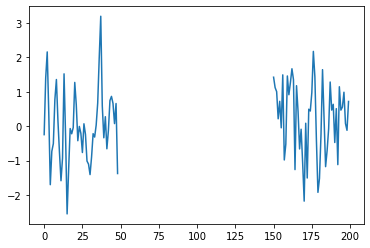

In [16]:
plt.plot(fiveVTS0[:,2])

In [436]:
T = 200
N = 5 # number of Nodes
E = fiveNet_edge
V = np.array([1,2,3,4,5])
t = np.arange(0,T)
node_features = 1

In [19]:
f = torch.tensor(fiveVTS0).reshape(200,5,1).float()

In [20]:
X = f[:199,:,:]
y = f[1:,:,:]

In [21]:
edge_index = torch.tensor(E)
edge_attr = torch.tensor(np.array([1,1,1,1,1,1,1,1,1,1]),dtype=torch.float32)

In [22]:
_ee = enumerate(zip(X,y))

In [23]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(X,y)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:33<00:00,  1.50it/s]


In [24]:
yhat = torch.stack([model(xt, edge_index, edge_attr) for xt in X]).detach().numpy()

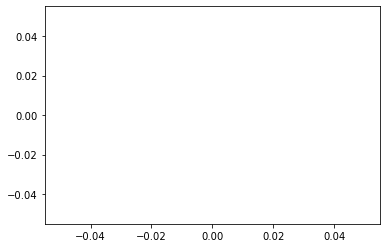

In [435]:
plt.plot(yhat[:,0].data)
plt.plot(yhat[:,1].data)
plt.plot(yhat[:,2].data)
plt.plot(yhat[:,3].data)

#### [2] GNAR - 언급!

GNAR에서 time 중 일부 값이 누락되었을때 그 time의 노드값은 다른 노드들에 영향을 끼치지 않은채 fit되게 됩니다.

따라서 GNARfit의 결과도 해당 노드의 missing 구간이 비어있습니다.

missing 값은 네트워크, 즉 엣지에 영향을 끼치지 않은채 계수가 추정됩니다.

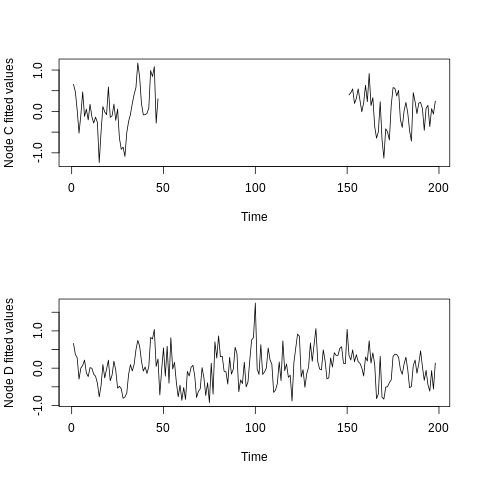

In [727]:
%%R
nafit <- GNARfit(vts = fiveVTS0, net = fiveNet, alphaOrder = 2, betaOrder = c(1, 1))
layout(matrix(c(1, 2), 2, 1))
plot(ts(fitted(nafit)[, 3]), ylab = "Node C fitted values")
plot(ts(fitted(nafit)[, 4]), ylab = "Node D fitted values")

In [730]:
%%R
summary(nafit)


Call:
lm(formula = yvec2 ~ dmat2 + 0)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.9530 -0.6423  0.0064  0.6978  3.3504 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
dmat2alpha1   0.223518   0.033626   6.647 5.22e-11 ***
dmat2beta1.1  0.495131   0.040471  12.234  < 2e-16 ***
dmat2alpha2   0.006051   0.032847   0.184   0.8539    
dmat2beta2.1 -0.096094   0.041510  -2.315   0.0208 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.008 on 883 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.2144,	Adjusted R-squared:  0.2109 
F-statistic: 60.26 on 4 and 883 DF,  p-value: < 2.2e-16

GNAR BIC: -0.747676

### 2) Random missing values

In [941]:
%%R
set.seed(1)
fiveVTSrandom <- fiveVTS
sampleindex = sort(sample(1:200, 100))
fiveVTSrandom[sampleindex,3] <- NA

In [942]:
%R -o fiveVTSrandom
%R -o sampleindex

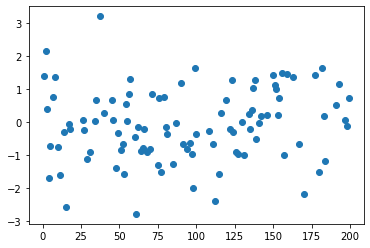

In [943]:
plt.plot(fiveVTSrandom[:,2],'o')

### 3) By 2

In [898]:
%%R
fiveVTStwo <- fiveVTS
indextwo <- rep(seq(1, by = 2, 200))
fiveVTStwo[indextwo, 3] <- NA

In [899]:
%R -o fiveVTStwo
%R -o indextwo

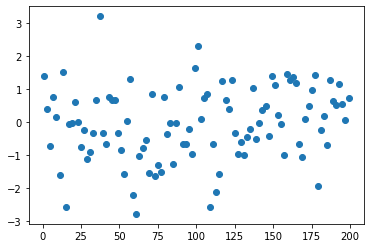

In [900]:
plt.plot(fiveVTStwo[:,2],'o')

# 1. missing을 채움. (mean, linear interpolation) 

## 1.1. Mean

### 1) Block

In [132]:
fiveVTS0_mean = fiveVTS0.copy()

In [133]:
fiveVTS0_mean[49:150,2] = np.mean(fiveVTS0[:49,2].tolist()+fiveVTS0[150:,2].tolist())

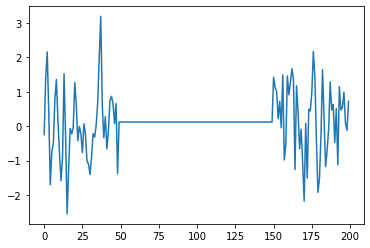

In [134]:
plt.plot(fiveVTS0_mean[:,2])

### 2) Random missing values

In [944]:
fiveVTSrandom_mean = fiveVTSrandom.copy()

In [990]:
df = pd.DataFrame(fiveVTSrandom[:,2])
mean_value = df.mean() # finds the mean value of the column A
df = df.fillna(mean_value) # replace missing values with the mean value

In [991]:
fiveVTSrandom_mean[:,2] = np.array(df).reshape(200,)

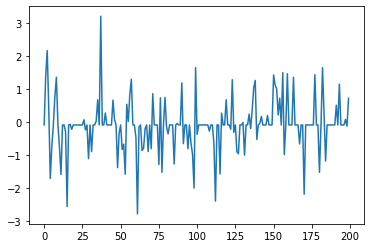

In [992]:
plt.plot(fiveVTSrandom_mean[:,2])

### 3) By 2

In [982]:
fiveVTStwo_mean = fiveVTStwo.copy()

In [977]:
df = pd.DataFrame(fiveVTStwo[:,2])
mean_value = df.mean() # finds the mean value of the column A
df = df.fillna(mean_value) # replace missing values with the mean value

In [984]:
fiveVTStwo_mean[:,2] = np.array(df).reshape(200,)

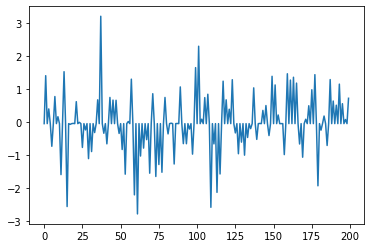

In [987]:
plt.plot(fiveVTStwo_mean[:,2])

## 1.2. linear interpolation

### 1) Block

In [1030]:
fiveVTS0_linearinterpolation = fiveVTS0.copy()

In [1031]:
# Sample data points
x = np.array([48,150])
y = np.array([fiveVTS0_linearinterpolation[48,2],fiveVTS0_linearinterpolation[150,2]])

# Create interpolating function
f = interp1d(x, y, kind='linear')

# Estimate y value for x = 2.5
y_interp = f(range(49,150))

In [1032]:
fiveVTS0_linearinterpolation[49:150,2] = y_interp

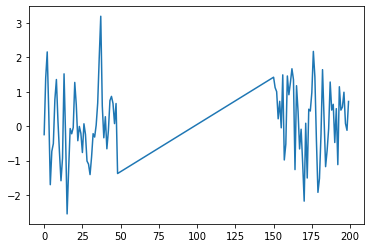

In [1033]:
plt.plot(fiveVTS0_linearinterpolation[:,2])

### 2) Random missing values

In [1339]:
fiveVTSrandom_linearinterpolation = fiveVTSrandom.copy()

In [1348]:
_df = pd.DataFrame(fiveVTSrandom_linearinterpolation[:,2])
_df.interpolate(method='linear', inplace=True)
_df = _df.fillna(0)

In [1349]:
fiveVTSrandom_linearinterpolation[:,2] = np.array(_df).reshape(200,)

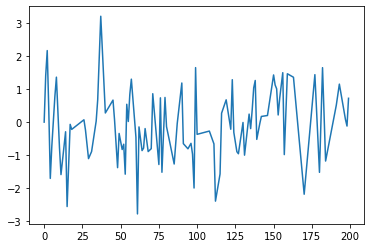

In [1350]:
plt.plot(fiveVTSrandom_linearinterpolation[:,2])

### 3) By 2

In [1351]:
fiveVTStwo_linearinterpolation = fiveVTStwo.copy()

In [1353]:
_df = pd.Series(fiveVTStwo_linearinterpolation[:,2])
_df.interpolate(method='linear', inplace=True)
_df = _df.fillna(0)

In [1354]:
fiveVTStwo_linearinterpolation[:,2] = _df

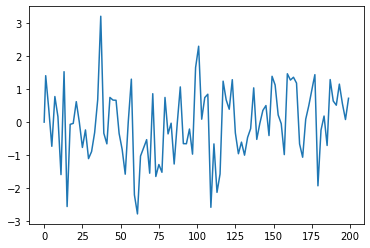

In [1355]:
plt.plot(fiveVTStwo_linearinterpolation[:,2])

## 1.3. Normal distribution Random Values

### 1) Block

In [703]:
fiveVTS0_normal = fiveVTS0.copy()

In [704]:
fiveVTS0_normal[49:150,2] = np.random.normal(loc=0,scale=0.2,size=101)

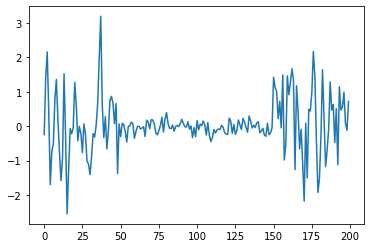

In [705]:
plt.plot(fiveVTS0_normal[:,2])

### 2) Random missing values

In [1051]:
fiveVTSrandom_normal = fiveVTSrandom.copy()

In [1054]:
fiveVTSrandom_normal[sampleindex-1,2] = np.random.normal(loc=0,scale=0.2,size=100)

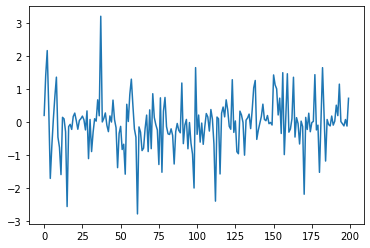

In [1055]:
plt.plot(fiveVTSrandom_normal[:,2])

### 3) By 2

In [1163]:
fiveVTStwo_normal = fiveVTStwo.copy()

In [1164]:
_df = pd.Series(fiveVTStwo_normal[:,2])
_df = _df.fillna(np.random.normal(loc=0,scale=0.2))

In [1165]:
fiveVTStwo_normal[:,2] = np.array(_df).reshape(200,)

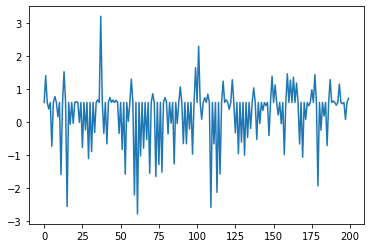

In [1166]:
plt.plot(fiveVTStwo_normal[:,2])

# 2. ST-GCN 을 사용하여 fhat을 구함. (스무딩1) 

In [1123]:
T = 200
N = 5 # number of Nodes
E = fiveNet_edge
V = np.array([1,2,3,4,5])
t = np.arange(0,T)
node_features = 1

In [1124]:
edge_index = torch.tensor(E)
edge_attr = torch.tensor(np.array([1,1,1,1,1,1,1,1,1,1]),dtype=torch.float32)

GNAR이랑 비교
- MSE 등 평가지표

## 2.1. Mean

### 1) Block

In [137]:
f_mean = torch.tensor(fiveVTS0_mean).reshape(200,5,1).float()

In [138]:
X_mean = f_mean[:199,:,:]
y_mean = f_mean[1:,:,:]

In [139]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(X_mean,y_mean)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:33<00:00,  1.49it/s]


In [140]:
fhat_mean = torch.stack([model(xt, edge_index, edge_attr) for xt in X_mean]).detach().numpy()

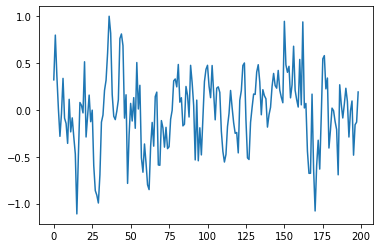

In [441]:
plt.plot(fhat_mean[:,2].data)

### 2) Random missing values

In [1125]:
f_fiveVTSrandom_mean = torch.tensor(fiveVTSrandom_mean).reshape(200,5,1).float()

In [1126]:
X_fiveVTSrandom_mean = f_fiveVTSrandom_mean[:199,:,:]
y_fiveVTSrandom_mean = f_fiveVTSrandom_mean[1:,:,:]

In [1127]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(X_fiveVTSrandom_mean,y_fiveVTSrandom_mean)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:31<00:00,  1.58it/s]


In [1128]:
fhat_fiveVTSrandom_mean = torch.stack([model(xt, edge_index, edge_attr) for xt in X_fiveVTSrandom_mean]).detach().numpy()

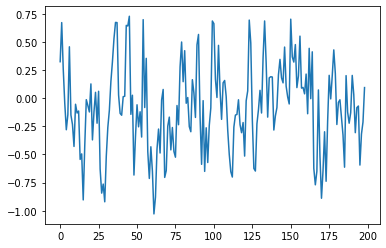

In [1129]:
plt.plot(fhat_fiveVTSrandom_mean[:,2].data)

### 3) By 2

In [1134]:
f_fiveVTStwo_mean = torch.tensor(fiveVTStwo_mean).reshape(200,5,1).float()

In [1135]:
X_fiveVTStwo_mean = f_fiveVTStwo_mean[:199,:,:]
y_fiveVTStwo_mean = f_fiveVTStwo_mean[1:,:,:]

In [1136]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(X_fiveVTStwo_mean,y_fiveVTStwo_mean)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:31<00:00,  1.58it/s]


In [1137]:
fhat_fiveVTStwo_mean = torch.stack([model(xt, edge_index, edge_attr) for xt in X_fiveVTStwo_mean]).detach().numpy()

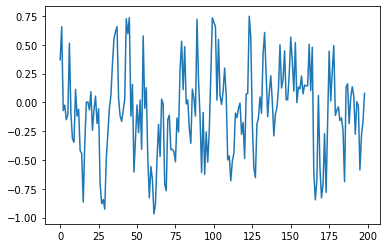

In [1138]:
plt.plot(fhat_fiveVTStwo_mean[:,2].data)

## 2.2. linear interpolation

### 1) Block

In [1399]:
f_linearinterpolation = torch.tensor(fiveVTS0_linearinterpolation).reshape(200,5,1).float()

In [1400]:
X_linearinterpolation = f_linearinterpolation[:199,:,:]
y_linearinterpolation = f_linearinterpolation[1:,:,:]

In [1401]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(X_linearinterpolation,y_linearinterpolation)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:43<00:00,  1.15it/s]


In [1402]:
fhat_linearinterpolation = torch.stack([model(xt, edge_index, edge_attr) for xt in X_linearinterpolation]).detach().numpy()

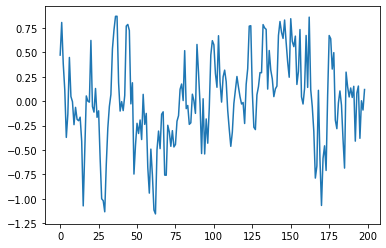

In [1403]:
plt.plot(fhat_linearinterpolation[:,2].data)

### 2) Random missing values

In [1356]:
f_fiveVTSrandom_linearinterpolation = torch.tensor(fiveVTSrandom_linearinterpolation).reshape(200,5,1).float()

In [1357]:
X_fiveVTSrandom_linearinterpolation = f_fiveVTSrandom_linearinterpolation[:199,:,:]
y_fiveVTSrandom_linearinterpolation = f_fiveVTSrandom_linearinterpolation[1:,:,:]

In [1358]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(X_fiveVTSrandom_linearinterpolation,y_fiveVTSrandom_linearinterpolation)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:32<00:00,  1.56it/s]


In [1359]:
fhat_fiveVTSrandom_linearinterpolation = torch.stack([model(xt, edge_index, edge_attr) for xt in X_fiveVTSrandom_linearinterpolation]).detach().numpy()

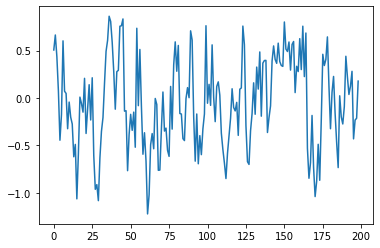

In [1360]:
plt.plot(fhat_fiveVTSrandom_linearinterpolation[:,2].data)

### 3) By 2

In [1361]:
f_fiveVTStwo_linearinterpolation = torch.tensor(fiveVTStwo_linearinterpolation).reshape(200,5,1).float()

In [1362]:
X_fiveVTStwo_linearinterpolation = f_fiveVTSrandom_linearinterpolation[:199,:,:]
y_fiveVTStwo_linearinterpolation = f_fiveVTSrandom_linearinterpolation[1:,:,:]

In [1363]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(X_fiveVTStwo_linearinterpolation,y_fiveVTStwo_linearinterpolation)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:31<00:00,  1.58it/s]


In [1364]:
fhat_fiveVTStwo_linearinterpolation = torch.stack([model(xt, edge_index, edge_attr) for xt in X_fiveVTStwo_linearinterpolation]).detach().numpy()

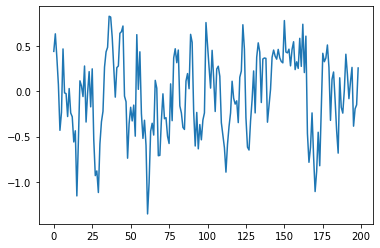

In [1365]:
plt.plot(fhat_fiveVTStwo_linearinterpolation[:,2].data)

## 2.3. Normal distribution Random Values

### 1) Block

In [708]:
f_normal = torch.tensor(fiveVTS0_normal).reshape(200,5,1).float()

In [709]:
X_normal = f_normal[:199,:,:]
y_normal = f_normal[1:,:,:]

In [710]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(X_normal,y_normal)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:35<00:00,  1.42it/s]


In [711]:
fhat_normal = torch.stack([model(xt, edge_index, edge_attr) for xt in X_normal]).detach().numpy()

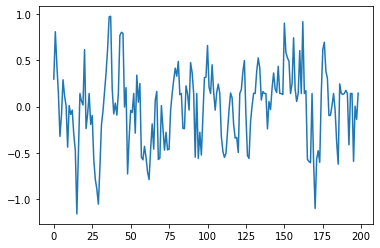

In [713]:
plt.plot(fhat_normal[:,2].data)

### 2) Random missing values

In [1228]:
f_fiveVTSrandom_normal = torch.tensor(fiveVTSrandom_normal).reshape(200,5,1).float()

In [1229]:
X_fiveVTSrandom_normal = f_fiveVTSrandom_normal[:199,:,:]
y_fiveVTSrandom_normal = f_fiveVTSrandom_normal[1:,:,:]

In [1230]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(X_fiveVTSrandom_normal,y_fiveVTSrandom_normal)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:31<00:00,  1.57it/s]


In [1231]:
fhat_fiveVTSrandom_normal = torch.stack([model(xt, edge_index, edge_attr) for xt in X_fiveVTSrandom_normal]).detach().numpy()

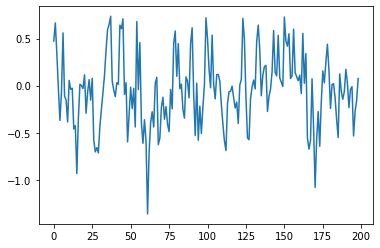

In [1232]:
plt.plot(fhat_fiveVTSrandom_normal[:,2].data)

### 3) By 2

In [1233]:
f_fiveVTStwo_normal = torch.tensor(fiveVTStwo_normal).reshape(200,5,1).float()

In [1234]:
X_fiveVTStwo_normal = f_fiveVTStwo_normal[:199,:,:]
y_fiveVTStwo_normal = f_fiveVTStwo_normal[1:,:,:]

In [1235]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(X_fiveVTStwo_normal,y_fiveVTStwo_normal)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:31<00:00,  1.56it/s]


In [1236]:
fhat_fiveVTStwo_normal = torch.stack([model(xt, edge_index, edge_attr) for xt in X_fiveVTStwo_normal]).detach().numpy()

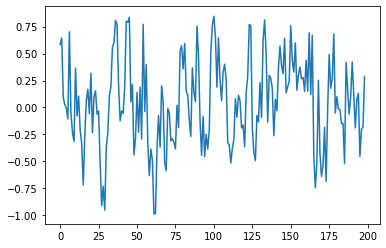

In [1237]:
plt.plot(fhat_fiveVTStwo_normal[:,2].data)

# 3. 2에서 얻은 fhat을 이용하여 그래프퓨리에변환+Ebayesthresh (스무딩2)  

- 그래프퓨리에변환을 하는 가중치
- 년도끼리 이어주어서 하나의 큰 그래프로 만든뒤에 GFT 
- Ebayesthresh 

## 3.1. Mean

### 3.1.1. Temporal

#### 1) Block

In [576]:
w=np.zeros((5,199,199))

In [577]:
for k in range(5):
    for i in range(199):
        for j in range(199):
            if i==j :
                w[k,i,j] = 0
            elif np.abs(i-j) <= 1 : 
                w[k,i,j] = 1

In [578]:
d = np.array([w[i].sum(axis=1) for i in range(5)])
D= np.array([np.diag(d[i]) for i in range(5)])
L = np.array([np.diag(1/np.sqrt(d[i])) @ (D[i]-w[i]) @ np.diag(1/np.sqrt(d[i])) for i in range(5)])
lamb, Psi  = np.linalg.eigh(L)[0],np.linalg.eigh(L)[1]
Lamb = np.array([np.diag(lamb[i]) for i in range(5)])    
fhatbar = np.hstack([Psi[i] @ fhat_mean[:,i] for i in range(5)])
_fhatbar = fhatbar.reshape(5,199)
power = _fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(_fhatbar[i]**2))) for i in range(5)])
fhatbar_threshed = np.where(power_threshed>0,_fhatbar,0)
fhatbarhat = np.array([Psi[i] @ fhatbar_threshed[i] for i in range(5)])    
fhatbarhat_mean_temporal = fhatbarhat.reshape(199,-1)

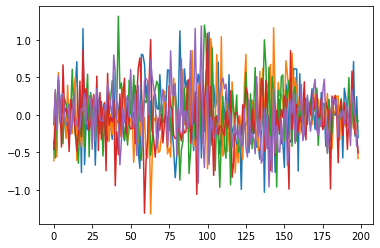

In [579]:
plt.plot(fhatbarhat_mean_temporal[:,0])
plt.plot(fhatbarhat_mean_temporal[:,1])
plt.plot(fhatbarhat_mean_temporal[:,2])
plt.plot(fhatbarhat_mean_temporal[:,3])
plt.plot(fhatbarhat_mean_temporal[:,4])

#### 2) Random missing values

In [ ]:
w=np.zeros((5,199,199))

In [ ]:
for k in range(5):
    for i in range(199):
        for j in range(199):
            if i==j :
                w[k,i,j] = 0
            elif np.abs(i-j) <= 1 : 
                w[k,i,j] = 1

In [1240]:
d = np.array([w[i].sum(axis=1) for i in range(5)])
D= np.array([np.diag(d[i]) for i in range(5)])
L = np.array([np.diag(1/np.sqrt(d[i])) @ (D[i]-w[i]) @ np.diag(1/np.sqrt(d[i])) for i in range(5)])
lamb, Psi  = np.linalg.eigh(L)[0],np.linalg.eigh(L)[1]
Lamb = np.array([np.diag(lamb[i]) for i in range(5)])    
fhatbar = np.hstack([Psi[i] @ fhat_fiveVTSrandom_mean[:,i] for i in range(5)])
_fhatbar = fhatbar.reshape(5,199)
power = _fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(_fhatbar[i]**2))) for i in range(5)])
fhatbar_threshed = np.where(power_threshed>0,_fhatbar,0)
fhatbarhat = np.array([Psi[i] @ fhatbar_threshed[i] for i in range(5)])    
fhatbarhat_random_mean_temporal = fhatbarhat.reshape(199,-1)

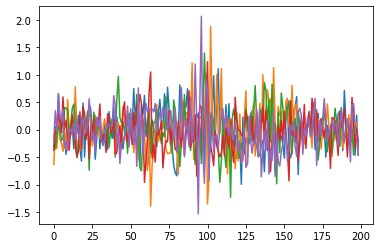

In [1243]:
plt.plot(fhatbarhat_random_mean_temporal[:,0])
plt.plot(fhatbarhat_random_mean_temporal[:,1])
plt.plot(fhatbarhat_random_mean_temporal[:,2])
plt.plot(fhatbarhat_random_mean_temporal[:,3])
plt.plot(fhatbarhat_random_mean_temporal[:,4])

#### 3) By 2

In [1244]:
w=np.zeros((5,199,199))

In [1245]:
for k in range(5):
    for i in range(199):
        for j in range(199):
            if i==j :
                w[k,i,j] = 0
            elif np.abs(i-j) <= 1 : 
                w[k,i,j] = 1

In [1246]:
d = np.array([w[i].sum(axis=1) for i in range(5)])
D= np.array([np.diag(d[i]) for i in range(5)])
L = np.array([np.diag(1/np.sqrt(d[i])) @ (D[i]-w[i]) @ np.diag(1/np.sqrt(d[i])) for i in range(5)])
lamb, Psi  = np.linalg.eigh(L)[0],np.linalg.eigh(L)[1]
Lamb = np.array([np.diag(lamb[i]) for i in range(5)])    
fhatbar = np.hstack([Psi[i] @ fhat_fiveVTStwo_mean[:,i] for i in range(5)])
_fhatbar = fhatbar.reshape(5,199)
power = _fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(_fhatbar[i]**2))) for i in range(5)])
fhatbar_threshed = np.where(power_threshed>0,_fhatbar,0)
fhatbarhat = np.array([Psi[i] @ fhatbar_threshed[i] for i in range(5)])    
fhatbarhat_twomean_temporal = fhatbarhat.reshape(199,-1)

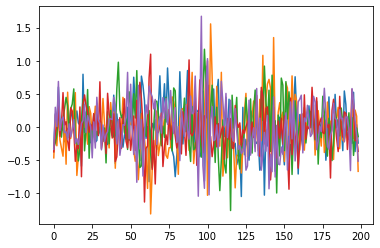

In [1247]:
plt.plot(fhatbarhat_twomean_temporal[:,0])
plt.plot(fhatbarhat_twomean_temporal[:,1])
plt.plot(fhatbarhat_twomean_temporal[:,2])
plt.plot(fhatbarhat_twomean_temporal[:,3])
plt.plot(fhatbarhat_twomean_temporal[:,4])

### 3.1.2. Spatio

#### 1) Block

In [602]:
w=np.zeros((5,5))

In [603]:
for i in range(5):
    for j in range(5):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [620]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ fhat_mean.reshape(5,199)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(5)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_mean_spatio = fhatbarhat.reshape(199,-1)

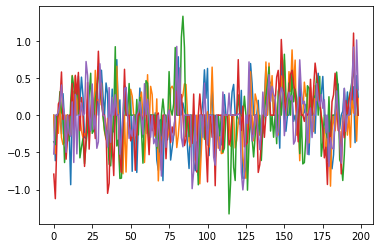

In [621]:
plt.plot(fhatbarhat_mean_spatio[:,0])
plt.plot(fhatbarhat_mean_spatio[:,1])
plt.plot(fhatbarhat_mean_spatio[:,2])
plt.plot(fhatbarhat_mean_spatio[:,3])
plt.plot(fhatbarhat_mean_spatio[:,4])

#### 2) Random missing values

In [1264]:
w=np.zeros((5,5))

In [1265]:
for i in range(5):
    for j in range(5):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [1266]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ fhat_fiveVTSrandom_mean.reshape(5,199)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(5)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_random_mean_spatio = fhatbarhat.reshape(199,-1)

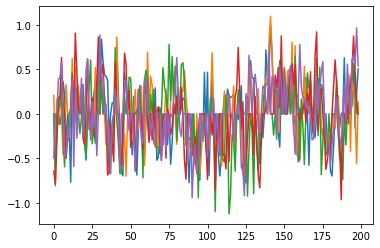

In [1267]:
plt.plot(fhatbarhat_random_mean_spatio[:,0])
plt.plot(fhatbarhat_random_mean_spatio[:,1])
plt.plot(fhatbarhat_random_mean_spatio[:,2])
plt.plot(fhatbarhat_random_mean_spatio[:,3])
plt.plot(fhatbarhat_random_mean_spatio[:,4])

#### 3) By 2

In [1268]:
w=np.zeros((5,5))

In [1269]:
for i in range(5):
    for j in range(5):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [1271]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ fhat_fiveVTStwo_mean.reshape(5,199)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(5)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_two_mean_spatio = fhatbarhat.reshape(199,-1)

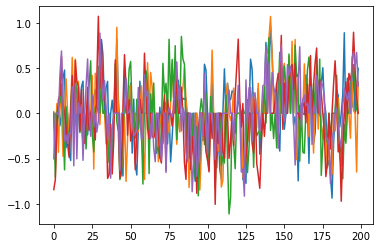

In [1272]:
plt.plot(fhatbarhat_two_mean_spatio[:,0])
plt.plot(fhatbarhat_two_mean_spatio[:,1])
plt.plot(fhatbarhat_two_mean_spatio[:,2])
plt.plot(fhatbarhat_two_mean_spatio[:,3])
plt.plot(fhatbarhat_two_mean_spatio[:,4])

### 3.1.3. Spatio-Temporal

#### 1) Block

In [643]:
w=np.zeros((995,995))

In [644]:
for i in range(995):
    for j in range(995):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [645]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ fhat_mean.reshape(995,1)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(995)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_mean_spatio_temporal = fhatbarhat.reshape(199,5,1)

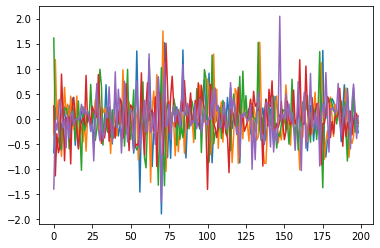

In [646]:
plt.plot(fhatbarhat_mean_spatio_temporal[:,0])
plt.plot(fhatbarhat_mean_spatio_temporal[:,1])
plt.plot(fhatbarhat_mean_spatio_temporal[:,2])
plt.plot(fhatbarhat_mean_spatio_temporal[:,3])
plt.plot(fhatbarhat_mean_spatio_temporal[:,4])

#### 2) Random missing values

In [1273]:
w=np.zeros((995,995))

In [1274]:
for i in range(995):
    for j in range(995):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [1275]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ fhat_fiveVTSrandom_mean.reshape(995,1)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(995)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_random_mean_spatio_temporal = fhatbarhat.reshape(199,5,1)

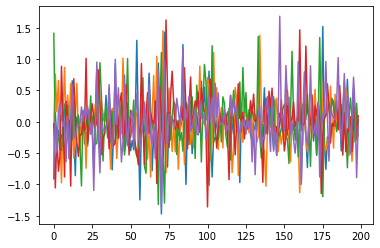

In [1276]:
plt.plot(fhatbarhat_random_mean_spatio_temporal[:,0])
plt.plot(fhatbarhat_random_mean_spatio_temporal[:,1])
plt.plot(fhatbarhat_random_mean_spatio_temporal[:,2])
plt.plot(fhatbarhat_random_mean_spatio_temporal[:,3])
plt.plot(fhatbarhat_random_mean_spatio_temporal[:,4])

#### 3) By 2

In [1277]:
w=np.zeros((995,995))

In [1278]:
for i in range(995):
    for j in range(995):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [1279]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ fhat_fiveVTStwo_mean.reshape(995,1)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(995)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_two_mean_spatio_temporal = fhatbarhat.reshape(199,5,1)

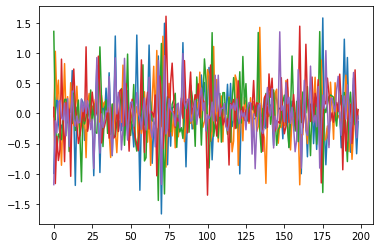

In [1280]:
plt.plot(fhatbarhat_two_mean_spatio_temporal[:,0])
plt.plot(fhatbarhat_two_mean_spatio_temporal[:,1])
plt.plot(fhatbarhat_two_mean_spatio_temporal[:,2])
plt.plot(fhatbarhat_two_mean_spatio_temporal[:,3])
plt.plot(fhatbarhat_two_mean_spatio_temporal[:,4])

## 3.2.linear interpolation

### 3.2.1. Temporal

#### 1) Block

In [1404]:
w=np.zeros((5,199,199))

In [1405]:
for k in range(5):
    for i in range(199):
        for j in range(199):
            if i==j :
                w[k,i,j] = 0
            elif np.abs(i-j) <= 1 : 
                w[k,i,j] = 1

In [1406]:
d = np.array([w[i].sum(axis=1) for i in range(5)])
D= np.array([np.diag(d[i]) for i in range(5)])
L = np.array([np.diag(1/np.sqrt(d[i])) @ (D[i]-w[i]) @ np.diag(1/np.sqrt(d[i])) for i in range(5)])
lamb, Psi  = np.linalg.eigh(L)[0],np.linalg.eigh(L)[1]
Lamb = np.array([np.diag(lamb[i]) for i in range(5)])
fhatbar = np.hstack([Psi[i] @ fhat_linearinterpolation[:,i] for i in range(5)])
_fhatbar = fhatbar.reshape(5,199)
power = _fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(_fhatbar[i]**2))) for i in range(5)])    
fhatbar_threshed = np.where(power_threshed>0,_fhatbar,0)
fhatbarhat = np.array([Psi[i] @ fhatbar_threshed[i] for i in range(5)])    
fhatbarhat_linearinterpolation_temporal = fhatbarhat.reshape(199,-1)

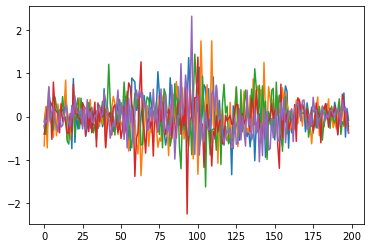

In [1407]:
plt.plot(fhatbarhat_linearinterpolation_temporal[:,0])
plt.plot(fhatbarhat_linearinterpolation_temporal[:,1])
plt.plot(fhatbarhat_linearinterpolation_temporal[:,2])
plt.plot(fhatbarhat_linearinterpolation_temporal[:,3])
plt.plot(fhatbarhat_linearinterpolation_temporal[:,4])

#### 2) Random missing values

In [1366]:
w=np.zeros((5,199,199))

In [1367]:
for k in range(5):
    for i in range(199):
        for j in range(199):
            if i==j :
                w[k,i,j] = 0
            elif np.abs(i-j) <= 1 : 
                w[k,i,j] = 1

In [1369]:
d = np.array([w[i].sum(axis=1) for i in range(5)])
D= np.array([np.diag(d[i]) for i in range(5)])
L = np.array([np.diag(1/np.sqrt(d[i])) @ (D[i]-w[i]) @ np.diag(1/np.sqrt(d[i])) for i in range(5)])
lamb, Psi  = np.linalg.eigh(L)[0],np.linalg.eigh(L)[1]
Lamb = np.array([np.diag(lamb[i]) for i in range(5)])
fhatbar = np.hstack([Psi[i] @ fhat_fiveVTSrandom_linearinterpolation[:,i] for i in range(5)])
_fhatbar = fhatbar.reshape(5,199)
power = _fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(_fhatbar[i]**2))) for i in range(5)])    
fhatbar_threshed = np.where(power_threshed>0,_fhatbar,0)
fhatbarhat = np.array([Psi[i] @ fhatbar_threshed[i] for i in range(5)])    
fhatbarhat_random_linearinterpolation_temporal = fhatbarhat.reshape(199,-1)

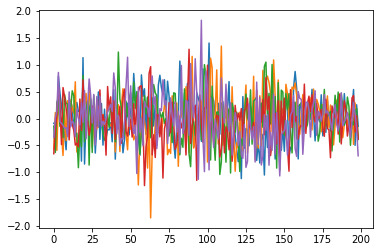

In [1370]:
plt.plot(fhatbarhat_random_linearinterpolation_temporal[:,0])
plt.plot(fhatbarhat_random_linearinterpolation_temporal[:,1])
plt.plot(fhatbarhat_random_linearinterpolation_temporal[:,2])
plt.plot(fhatbarhat_random_linearinterpolation_temporal[:,3])
plt.plot(fhatbarhat_random_linearinterpolation_temporal[:,4])

#### 3) By 2

In [1371]:
w=np.zeros((5,199,199))

In [1372]:
for k in range(5):
    for i in range(199):
        for j in range(199):
            if i==j :
                w[k,i,j] = 0
            elif np.abs(i-j) <= 1 : 
                w[k,i,j] = 1

In [1373]:
d = np.array([w[i].sum(axis=1) for i in range(5)])
D= np.array([np.diag(d[i]) for i in range(5)])
L = np.array([np.diag(1/np.sqrt(d[i])) @ (D[i]-w[i]) @ np.diag(1/np.sqrt(d[i])) for i in range(5)])
lamb, Psi  = np.linalg.eigh(L)[0],np.linalg.eigh(L)[1]
Lamb = np.array([np.diag(lamb[i]) for i in range(5)])
fhatbar = np.hstack([Psi[i] @ fhat_fiveVTStwo_linearinterpolation[:,i] for i in range(5)])
_fhatbar = fhatbar.reshape(5,199)
power = _fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(_fhatbar[i]**2))) for i in range(5)])    
fhatbar_threshed = np.where(power_threshed>0,_fhatbar,0)
fhatbarhat = np.array([Psi[i] @ fhatbar_threshed[i] for i in range(5)])    
fhatbarhat_two_linearinterpolation_temporal = fhatbarhat.reshape(199,-1)

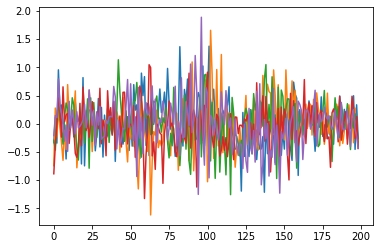

In [1374]:
plt.plot(fhatbarhat_two_linearinterpolation_temporal[:,0])
plt.plot(fhatbarhat_two_linearinterpolation_temporal[:,1])
plt.plot(fhatbarhat_two_linearinterpolation_temporal[:,2])
plt.plot(fhatbarhat_two_linearinterpolation_temporal[:,3])
plt.plot(fhatbarhat_two_linearinterpolation_temporal[:,4])

### 3.2.2. Spatio

#### 1) Block

In [1408]:
w=np.zeros((5,5))

In [1409]:
for i in range(5):
    for j in range(5):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [1410]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ fhat_linearinterpolation.reshape(5,199)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(5)])    
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_linearinterpolation_spatio = fhatbarhat.reshape(199,-1)

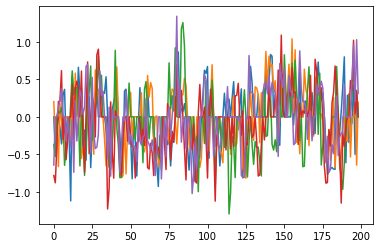

In [1411]:
plt.plot(fhatbarhat_linearinterpolation_spatio[:,0])
plt.plot(fhatbarhat_linearinterpolation_spatio[:,1])
plt.plot(fhatbarhat_linearinterpolation_spatio[:,2])
plt.plot(fhatbarhat_linearinterpolation_spatio[:,3])
plt.plot(fhatbarhat_linearinterpolation_spatio[:,4])

#### 2) Random missing values

In [1375]:
w=np.zeros((5,5))

In [1376]:
for i in range(5):
    for j in range(5):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [1377]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ fhat_fiveVTSrandom_linearinterpolation.reshape(5,199)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(5)])    
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_random_linearinterpolation_spatio = fhatbarhat.reshape(199,-1)

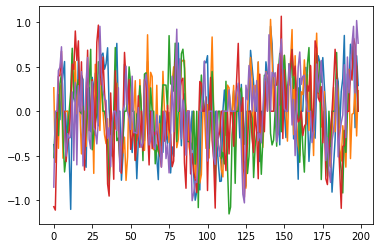

In [1378]:
plt.plot(fhatbarhat_random_linearinterpolation_spatio[:,0])
plt.plot(fhatbarhat_random_linearinterpolation_spatio[:,1])
plt.plot(fhatbarhat_random_linearinterpolation_spatio[:,2])
plt.plot(fhatbarhat_random_linearinterpolation_spatio[:,3])
plt.plot(fhatbarhat_random_linearinterpolation_spatio[:,4])

#### 3) By 2

In [1382]:
w=np.zeros((5,5))

In [1383]:
for i in range(5):
    for j in range(5):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [1384]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ fhat_fiveVTStwo_linearinterpolation.reshape(5,199)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(5)])    
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_two_linearinterpolation_spatio = fhatbarhat.reshape(199,-1)

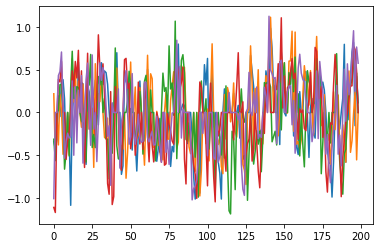

In [1385]:
plt.plot(fhatbarhat_two_linearinterpolation_spatio[:,0])
plt.plot(fhatbarhat_two_linearinterpolation_spatio[:,1])
plt.plot(fhatbarhat_two_linearinterpolation_spatio[:,2])
plt.plot(fhatbarhat_two_linearinterpolation_spatio[:,3])
plt.plot(fhatbarhat_two_linearinterpolation_spatio[:,4])

### 3.2.3. Spatio-Temporal

#### 1) Block

In [1412]:
w=np.zeros((995,995))

In [1413]:
for i in range(995):
    for j in range(995):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [1414]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ fhat_linearinterpolation.reshape(995,1)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(995)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhat_linearinterpolation_spatio_temporal = fhatbarhat.reshape(199,5,1)

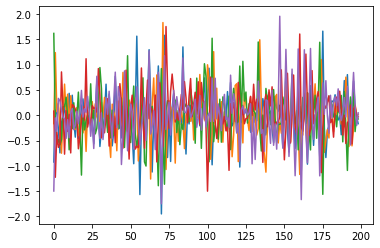

In [1415]:
plt.plot(fhat_linearinterpolation_spatio_temporal[:,0])
plt.plot(fhat_linearinterpolation_spatio_temporal[:,1])
plt.plot(fhat_linearinterpolation_spatio_temporal[:,2])
plt.plot(fhat_linearinterpolation_spatio_temporal[:,3])
plt.plot(fhat_linearinterpolation_spatio_temporal[:,4])

#### 2) Random missing values

In [1388]:
w=np.zeros((995,995))

In [1389]:
for i in range(995):
    for j in range(995):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [1390]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ fhat_fiveVTSrandom_linearinterpolation.reshape(995,1)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(995)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhat_random_linearinterpolation_spatio_temporal = fhatbarhat.reshape(199,5,1)

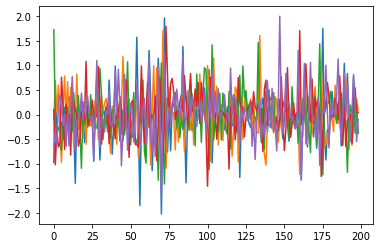

In [1391]:
plt.plot(fhat_random_linearinterpolation_spatio_temporal[:,0])
plt.plot(fhat_random_linearinterpolation_spatio_temporal[:,1])
plt.plot(fhat_random_linearinterpolation_spatio_temporal[:,2])
plt.plot(fhat_random_linearinterpolation_spatio_temporal[:,3])
plt.plot(fhat_random_linearinterpolation_spatio_temporal[:,4])

#### 3) By 2

In [1395]:
w=np.zeros((995,995))

In [1396]:
for i in range(995):
    for j in range(995):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [1397]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ fhat_fiveVTStwo_linearinterpolation.reshape(995,1)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(995)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhat_two_linearinterpolation_spatio_temporal = fhatbarhat.reshape(199,5,1)

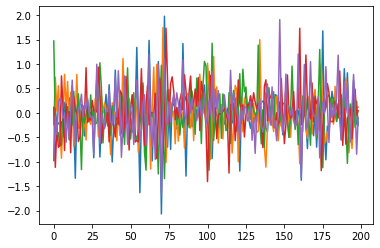

In [1398]:
plt.plot(fhat_two_linearinterpolation_spatio_temporal[:,0])
plt.plot(fhat_two_linearinterpolation_spatio_temporal[:,1])
plt.plot(fhat_two_linearinterpolation_spatio_temporal[:,2])
plt.plot(fhat_two_linearinterpolation_spatio_temporal[:,3])
plt.plot(fhat_two_linearinterpolation_spatio_temporal[:,4])

## 3.3. Normal distribution

### 3.3.1. Temporal

#### 1) Block

In [714]:
w=np.zeros((5,199,199))

In [715]:
for k in range(5):
    for i in range(199):
        for j in range(199):
            if i==j :
                w[k,i,j] = 0
            elif np.abs(i-j) <= 1 : 
                w[k,i,j] = 1

In [716]:
d = np.array([w[i].sum(axis=1) for i in range(5)])
D= np.array([np.diag(d[i]) for i in range(5)])
L = np.array([np.diag(1/np.sqrt(d[i])) @ (D[i]-w[i]) @ np.diag(1/np.sqrt(d[i])) for i in range(5)])
lamb, Psi  = np.linalg.eigh(L)[0],np.linalg.eigh(L)[1]
Lamb = np.array([np.diag(lamb[i]) for i in range(5)])    
fhatbar = np.hstack([Psi[i] @ fhat_normal[:,i] for i in range(5)])
_fhatbar = fhatbar.reshape(5,199)
power = _fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(_fhatbar[i]**2))) for i in range(5)])
fhatbar_threshed = np.where(power_threshed>0,_fhatbar,0)
fhatbarhat = np.array([Psi[i] @ fhatbar_threshed[i] for i in range(5)])    
fhatbarhat_normal_temporal = fhatbarhat.reshape(199,-1)

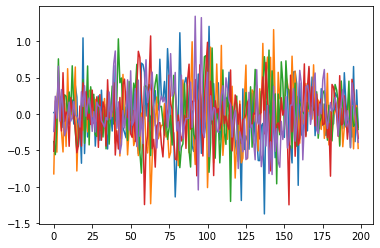

In [717]:
plt.plot(fhatbarhat_normal_temporal[:,0])
plt.plot(fhatbarhat_normal_temporal[:,1])
plt.plot(fhatbarhat_normal_temporal[:,2])
plt.plot(fhatbarhat_normal_temporal[:,3])
plt.plot(fhatbarhat_normal_temporal[:,4])

#### 2) Random missing values

In [1292]:
w=np.zeros((5,199,199))

In [1293]:
for k in range(5):
    for i in range(199):
        for j in range(199):
            if i==j :
                w[k,i,j] = 0
            elif np.abs(i-j) <= 1 : 
                w[k,i,j] = 1

In [1294]:
d = np.array([w[i].sum(axis=1) for i in range(5)])
D= np.array([np.diag(d[i]) for i in range(5)])
L = np.array([np.diag(1/np.sqrt(d[i])) @ (D[i]-w[i]) @ np.diag(1/np.sqrt(d[i])) for i in range(5)])
lamb, Psi  = np.linalg.eigh(L)[0],np.linalg.eigh(L)[1]
Lamb = np.array([np.diag(lamb[i]) for i in range(5)])    
fhatbar = np.hstack([Psi[i] @ fhat_fiveVTSrandom_normal[:,i] for i in range(5)])
_fhatbar = fhatbar.reshape(5,199)
power = _fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(_fhatbar[i]**2))) for i in range(5)])
fhatbar_threshed = np.where(power_threshed>0,_fhatbar,0)
fhatbarhat = np.array([Psi[i] @ fhatbar_threshed[i] for i in range(5)])    
fhatbarhat_random_normal_temporal = fhatbarhat.reshape(199,-1)

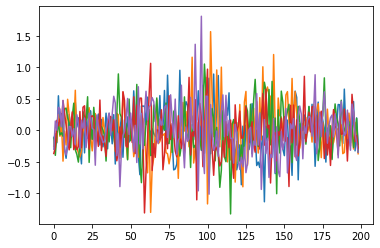

In [1295]:
plt.plot(fhatbarhat_random_normal_temporal[:,0])
plt.plot(fhatbarhat_random_normal_temporal[:,1])
plt.plot(fhatbarhat_random_normal_temporal[:,2])
plt.plot(fhatbarhat_random_normal_temporal[:,3])
plt.plot(fhatbarhat_random_normal_temporal[:,4])

#### 3) By 2

In [1296]:
w=np.zeros((5,199,199))

In [1297]:
for k in range(5):
    for i in range(199):
        for j in range(199):
            if i==j :
                w[k,i,j] = 0
            elif np.abs(i-j) <= 1 : 
                w[k,i,j] = 1

In [1298]:
d = np.array([w[i].sum(axis=1) for i in range(5)])
D= np.array([np.diag(d[i]) for i in range(5)])
L = np.array([np.diag(1/np.sqrt(d[i])) @ (D[i]-w[i]) @ np.diag(1/np.sqrt(d[i])) for i in range(5)])
lamb, Psi  = np.linalg.eigh(L)[0],np.linalg.eigh(L)[1]
Lamb = np.array([np.diag(lamb[i]) for i in range(5)])    
fhatbar = np.hstack([Psi[i] @ fhat_fiveVTStwo_normal[:,i] for i in range(5)])
_fhatbar = fhatbar.reshape(5,199)
power = _fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(_fhatbar[i]**2))) for i in range(5)])
fhatbar_threshed = np.where(power_threshed>0,_fhatbar,0)
fhatbarhat = np.array([Psi[i] @ fhatbar_threshed[i] for i in range(5)])    
fhatbarhat_two_normal_temporal = fhatbarhat.reshape(199,-1)

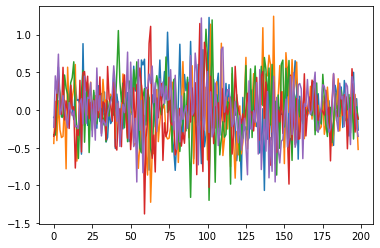

In [1299]:
plt.plot(fhatbarhat_two_normal_temporal[:,0])
plt.plot(fhatbarhat_two_normal_temporal[:,1])
plt.plot(fhatbarhat_two_normal_temporal[:,2])
plt.plot(fhatbarhat_two_normal_temporal[:,3])
plt.plot(fhatbarhat_two_normal_temporal[:,4])

### 3.3.2. Spatio

#### 1) Block

In [718]:
w=np.zeros((5,5))

In [719]:
for i in range(5):
    for j in range(5):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [720]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ fhat_normal.reshape(5,199)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(5)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_normal_spatio = fhatbarhat.reshape(199,-1)

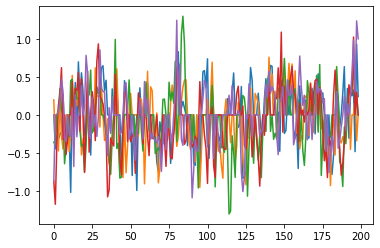

In [721]:
plt.plot(fhatbarhat_normal_spatio[:,0])
plt.plot(fhatbarhat_normal_spatio[:,1])
plt.plot(fhatbarhat_normal_spatio[:,2])
plt.plot(fhatbarhat_normal_spatio[:,3])
plt.plot(fhatbarhat_normal_spatio[:,4])

#### 2) Random missing values

In [1300]:
w=np.zeros((5,5))

In [1301]:
for i in range(5):
    for j in range(5):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [1302]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ fhat_fiveVTSrandom_normal.reshape(5,199)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(5)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_random_normal_spatio = fhatbarhat.reshape(199,-1)

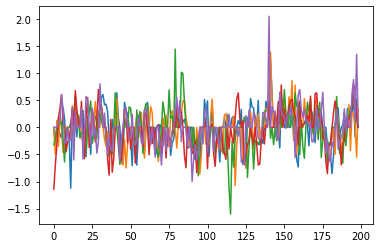

In [1303]:
plt.plot(fhatbarhat_random_normal_spatio[:,0])
plt.plot(fhatbarhat_random_normal_spatio[:,1])
plt.plot(fhatbarhat_random_normal_spatio[:,2])
plt.plot(fhatbarhat_random_normal_spatio[:,3])
plt.plot(fhatbarhat_random_normal_spatio[:,4])

#### 3) By 2

In [1305]:
w=np.zeros((5,5))

In [1306]:
for i in range(5):
    for j in range(5):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [1307]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ fhat_fiveVTStwo_normal.reshape(5,199)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(5)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_two_normal_spatio = fhatbarhat.reshape(199,-1)

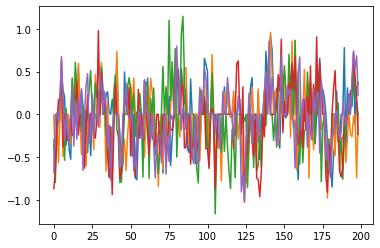

In [1308]:
plt.plot(fhatbarhat_two_normal_spatio[:,0])
plt.plot(fhatbarhat_two_normal_spatio[:,1])
plt.plot(fhatbarhat_two_normal_spatio[:,2])
plt.plot(fhatbarhat_two_normal_spatio[:,3])
plt.plot(fhatbarhat_two_normal_spatio[:,4])

### 3.3.3. Spatio-Temporal

#### 1) Block

In [1288]:
w=np.zeros((995,995))

In [1289]:
for i in range(995):
    for j in range(995):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [1290]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ fhat_normal.reshape(995,1)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(995)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_normal_spatio_temporal = fhatbarhat.reshape(199,5,1)

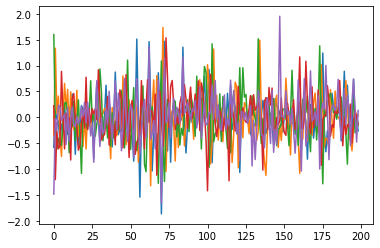

In [1291]:
plt.plot(fhatbarhat_normal_spatio_temporal[:,0])
plt.plot(fhatbarhat_normal_spatio_temporal[:,1])
plt.plot(fhatbarhat_normal_spatio_temporal[:,2])
plt.plot(fhatbarhat_normal_spatio_temporal[:,3])
plt.plot(fhatbarhat_normal_spatio_temporal[:,4])

#### 2) Random missing values

In [1309]:
w=np.zeros((995,995))

In [1310]:
for i in range(995):
    for j in range(995):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [1311]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ fhat_fiveVTSrandom_normal.reshape(995,1)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(995)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_random_normal_spatio_temporal = fhatbarhat.reshape(199,5,1)

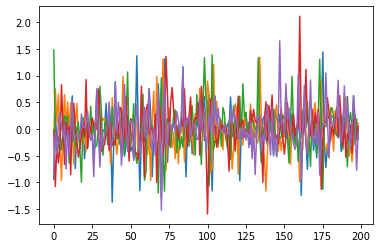

In [1313]:
plt.plot(fhatbarhat_random_normal_spatio_temporal[:,0])
plt.plot(fhatbarhat_random_normal_spatio_temporal[:,1])
plt.plot(fhatbarhat_random_normal_spatio_temporal[:,2])
plt.plot(fhatbarhat_random_normal_spatio_temporal[:,3])
plt.plot(fhatbarhat_random_normal_spatio_temporal[:,4])

#### 3) By 2

In [1314]:
w=np.zeros((995,995))

In [1315]:
for i in range(995):
    for j in range(995):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [1316]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ fhat_fiveVTStwo_normal.reshape(995,1)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(995)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_two_normal_spatio_temporal = fhatbarhat.reshape(199,5,1)

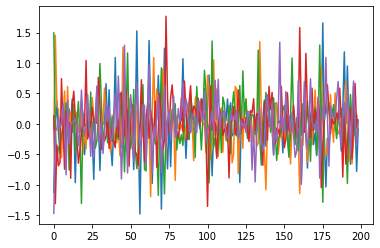

In [1317]:
plt.plot(fhatbarhat_two_normal_spatio_temporal[:,0])
plt.plot(fhatbarhat_two_normal_spatio_temporal[:,1])
plt.plot(fhatbarhat_two_normal_spatio_temporal[:,2])
plt.plot(fhatbarhat_two_normal_spatio_temporal[:,3])
plt.plot(fhatbarhat_two_normal_spatio_temporal[:,4])

# 4. 1로 돌아가서 반복 